In [1]:
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
import yaml

import numpy as np
import numexpr
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scripts.general import data


tqdm.pandas(desc='Pandas op')
MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)


plt.rcParams['font.size'] = 14

%load_ext autoreload
%autoreload 2

In [2]:
exp_config_fname = '../20211223_182228/experiment_config.yaml'

with open(exp_config_fname, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq', 'Systematic_Name', 'Standard_Name', 'Median_molecules_per_cell']
]
seq_data = seq_data.assign(seq_len = seq_data['seq'].str.len())
seq_data = seq_data.assign(
    abundance_bin = pd.qcut(seq_data['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)

In [3]:
seq_data.shape

(4750, 7)

## Overall AA frequency - abundance per bin

20 variables for each bin.

In [4]:
def count_aa_freq_by_group(grp_df):
    counts = grp_df['seq'].map(Counter).sum()
    counts = pd.DataFrame.from_records(list(counts.items()), columns = ['AA', 'count'])
    tot_count = counts['count'].sum()
    counts = counts.assign(freq = counts['count'] / tot_count)
    counts = counts.sort_values('freq', ascending=False)
    return counts


background_aa_counts = (
    seq_data
    .groupby('abundance_bin')
    .apply(count_aa_freq_by_group)
    .reset_index().drop(columns='level_1')
)

background_aa_counts.head(2)

,abundance_bin,AA,count,freq
0,1,L,25252,0.099297
1,1,S,23899,0.093977


In [5]:
hue_order = list(background_aa_counts['AA'].sort_values().unique())

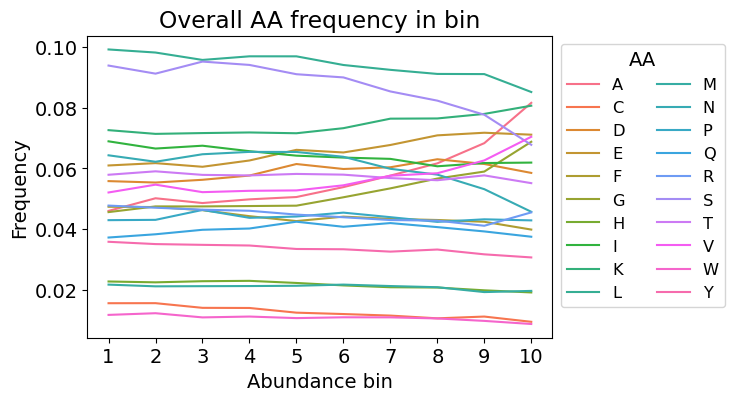

In [6]:
plt.figure(dpi=100)
plt.rcParams['legend.fontsize'] = 'small'

ax = sns.lineplot(
    data = background_aa_counts,
    x = 'abundance_bin',
    y = 'freq',
    hue = 'AA',
    hue_order = hue_order
)

ax.set(
    title='Overall AA frequency in bin',
    xlabel='Abundance bin',
    ylabel='Frequency'
)

ax.set_xticks(range(1, 11))

sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), ncol=2)

In [7]:
aa_freq_over_bins = (
    background_aa_counts.pivot(index='abundance_bin', columns='AA', values='freq')
)

aa_freq_over_bins

AA,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
abundance_bin,,,,,,,,,,,,,,,,,,,,
1,0.045980,0.015497,0.055818,0.060985,0.047348,0.045583,0.022673,0.068956,0.072648,0.099297,0.021639,0.064339,0.042924,0.037191,0.047737,0.093977,0.057918,0.052067,0.011639,0.035783
2,0.050156,0.015513,0.055352,0.061754,0.047253,0.047465,0.022392,0.066572,0.071418,0.098278,0.021073,0.062212,0.043026,0.038265,0.047040,0.091309,0.059054,0.054647,0.012194,0.035026
3,0.048578,0.013970,0.056256,0.060553,0.046223,0.047462,0.022764,0.067512,0.071683,0.095836,0.021123,0.064690,0.046301,0.039746,0.046379,0.095287,0.057877,0.052172,0.010814,0.034773
4,0.049795,0.013924,0.057657,0.062630,0.044240,0.047588,0.022885,0.065703,0.071886,0.097030,0.021167,0.065470,0.043694,0.040167,0.046026,0.094185,0.057691,0.052615,0.011094,0.034554
5,0.050564,0.012380,0.061463,0.066145,0.042622,0.047710,0.022188,0.064224,0.071624,0.097023,0.021255,0.065446,0.044128,0.042412,0.044768,0.091119,0.058193,0.052744,0.010581,0.033410
6,0.053836,0.011922,0.059822,0.065279,0.044087,0.050478,0.021376,0.063590,0.073298,0.094165,0.021646,0.063854,0.045411,0.040739,0.043887,0.090063,0.057953,0.054430,0.010848,0.033314
7,0.057639,0.011414,0.060394,0.067747,0.043341,0.053424,0.020772,0.063165,0.076440,0.092565,0.021169,0.059888,0.043912,0.041961,0.042964,0.085431,0.056815,0.057599,0.010828,0.032533
8,0.061680,0.010506,0.063038,0.070927,0.042976,0.056663,0.020669,0.060714,0.076511,0.091213,0.020779,0.057962,0.042359,0.040627,0.042762,0.082394,0.056106,0.058420,0.010467,0.033226
9,0.068353,0.011089,0.061479,0.071792,0.042392,0.058972,0.019757,0.061790,0.078012,0.091158,0.019173,0.053154,0.043206,0.039204,0.041074,0.077733,0.057708,0.062653,0.009659,0.031640


In [8]:
def percent_deltas(values: np.ndarray) -> np.ndarray:
    delta_percent = np.zeros(values.shape[0] - 1, dtype='float32')
    for i in range(1, values.shape[0]):
        delta_percent[i - 1] = 100 * (values[i] - values[i - 1]) / values[i - 1]
    return delta_percent


freq_deltas_over_bins = background_aa_counts.groupby('AA').apply(
    lambda gdf: percent_deltas(gdf.sort_values('abundance_bin')['freq'].values)
)

freq_deltas_over_bins_labels = list(freq_deltas_over_bins.index)
freq_deltas_over_bins = np.stack(freq_deltas_over_bins.values).T

In [9]:
freq_deltas_over_bins.shape

(9, 20)

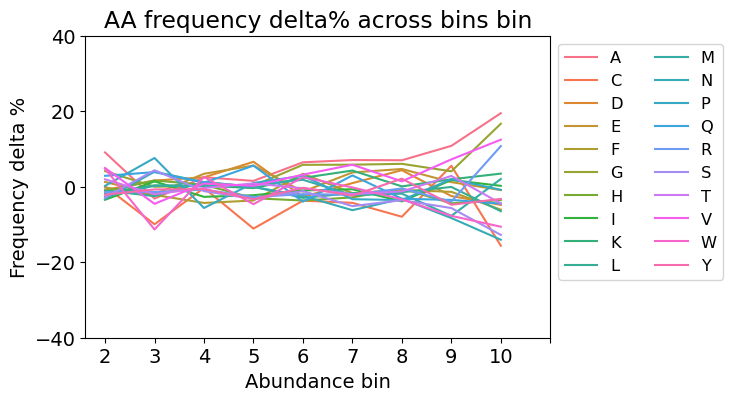

In [10]:
plt.figure(dpi=100)


ax = sns.lineplot(
    freq_deltas_over_bins,
    dashes = False,
)

ax.set(
    title='AA frequency delta% across bins bin',
    ylabel='Frequency delta %',
    xlabel='Abundance bin',
    ylim=(-40, 40)
)

ax.set_xticks(range(10))
ax.set_xticklabels(range(2, 11))

sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1), 
                labels = freq_deltas_over_bins_labels,
                ncol=2)

## Frequency CVs

In [11]:
aa_cv_by_abundance = (
    background_aa_counts.groupby('AA')['freq'].apply(stats.variation)
    .rename('Frequency CV %').reset_index()
)

aa_cv_by_abundance['Frequency CV %'] = aa_cv_by_abundance['Frequency CV %'] * 100

Text(5, 15, 'Mean CV = 7.07 %')

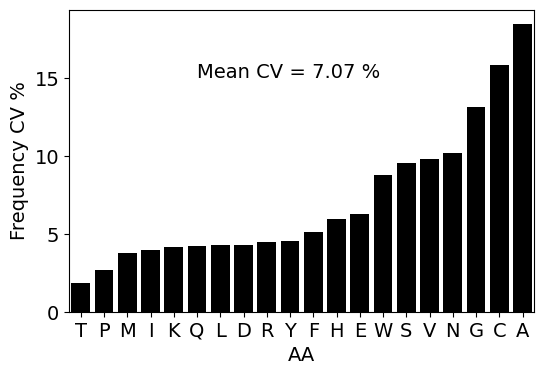

In [12]:
plt.figure(dpi=100, figsize=(6, 4))

sns.barplot(
    data = aa_cv_by_abundance,
    x = 'AA', y = 'Frequency CV %',
    color = 'black',
    order = aa_cv_by_abundance.sort_values('Frequency CV %')['AA']
)

plt.annotate(f"Mean CV = {aa_cv_by_abundance['Frequency CV %'].mean():.2f} %", xy = (5, 15))

# plt.savefig('AA_freq_var_by_abundance.png')

## Linear Model AA freq ~ abunadnce

### AA freq - abundance per protein

In [13]:
def seq_aa_freq(seq: str) -> dict:
    """
    Single frequencies are wrapped in a list to ease downstream processing 
    (pd.DataFrame conversion esp.)
    """
    counts = Counter(seq, )    
    freq = {
        aa: [c / len(seq)] for aa, c in counts.items()
    }
    return freq


seq_frequencies = pd.concat(
    seq_data['seq'].progress_apply(
        lambda s: pd.DataFrame.from_dict(seq_aa_freq(s), orient='columns')
    ).values
)

seq_frequencies = seq_frequencies.fillna(0)

Pandas op:   0%|          | 0/4750 [00:00<?, ?it/s]

Amino acids not present in a seq during counting will have NaN entries, so fill with zero

In [14]:
seq_frequencies = seq_frequencies.assign(
    index = seq_data.index
).set_index('index')

seq_freq_and_abundance = pd.concat([
        seq_data[['swissprot_ac', 'Median_molecules_per_cell', 'seq']],
        seq_frequencies
    ],
    axis=1
)

In [15]:
seq_frequencies.shape

(4750, 20)

In [16]:
seq_freq_and_abundance.to_csv('aa_freq.csv.gz', index=False, compression='gzip')

In [17]:
seq_freq_and_abundance.head(2)

,swissprot_ac,Median_molecules_per_cell,seq,M,S,Q,D,V,L,I,...,A,N,T,K,F,W,G,Y,E,R
0,P47095,4007.0,MSSQDVLIHSDDPCHPANLICTLCKQFFHNNWCTGTGGGISIKDPN...,0.036885,0.049180,0.032787,0.069672,0.036885,0.077869,0.098361,...,0.069672,0.040984,0.049180,0.086066,0.045082,0.008197,0.053279,0.036885,0.049180,0.016393
1,P25360,1197.0,MRFSHFLKYNAVPEWQNHYLDYNELKNLIYTLQTDELKQETPTGDL...,0.027086,0.092091,0.029252,0.049837,0.057421,0.114843,0.083424,...,0.062839,0.044420,0.062839,0.070423,0.058505,0.013001,0.060672,0.023835,0.057421,0.027086


In [19]:
aa_list = aa_cv_by_abundance['AA'].unique().tolist()

### Recreate train-test split

In [20]:
from scripts.general import preprocess


with Path('../20211223_182228/data/config.yaml').open('r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

data_root = os.path.expanduser(config['data_root'])
fasta_fname = Path(data_root) / config['protein_sequence']
abundances_fname = Path(data_root) / config['protein_abundance']
median_abundances = pd.read_csv('../../data/ho2018/prot_abundance_molecules_per_cell_no_gfp.csv')


BOXCOX_LAMBDA = -0.05155

all_sequences = preprocess.fasta_to_seq_df(fasta_fname)
abundances = pd.read_csv(abundances_fname)

seq_and_abundances = pd.merge(all_sequences, abundances, on='swissprot_ac')[
    ['swissprot_ac', 'seq', 'Median_molecules_per_cell']
]
seq_and_abundances = seq_and_abundances.query('Median_molecules_per_cell > 1e-5')
abundances = seq_and_abundances['Median_molecules_per_cell'].values
abundances = stats.boxcox(seq_and_abundances['Median_molecules_per_cell'].values,
                          lmbda=BOXCOX_LAMBDA)
sequences = seq_and_abundances['seq'].values


# Recreate splitting from training
random_seed = 42
(sequences_train, sequences_test,
 abundances_train, abundances_test) = data.split_on_unique_inputs(sequences, abundances,
                                                                   test_size=0.2,
                                                                   shuffle=True,
                                                                   random_state=random_seed)
(sequences_valid, sequences_test,
 abundances_valid, abundances_test) = data.split_on_unique_inputs(sequences_test, abundances_test,
                                                                   test_size=0.5,
                                                                   shuffle=True,
                                                                   random_state=random_seed)

set(sequences_test).intersection(set(sequences_train))

set()

### Linear Model

In [21]:
from sklearn.linear_model import LinearRegression


lm = LinearRegression().fit(
    X = seq_freq_and_abundance.query('seq in @sequences_train')[aa_list],     
    y = seq_freq_and_abundance.query('seq in @sequences_train')['Median_molecules_per_cell']
)

lm.score(
    X = seq_freq_and_abundance.query('seq in @sequences_test')[aa_list],
    y = seq_freq_and_abundance.query('seq in @sequences_test')['Median_molecules_per_cell']
)

0.20610931301129132

/tmp/ipykernel_54702/201184444.py:4: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(lm.predict(seq_freq_and_abundance.query('seq in @sequences_test')[aa_list])),
/tmp/ipykernel_54702/201184444.py:4: RuntimeWarning: invalid value encountered in log10
  x = np.log10(lm.predict(seq_freq_and_abundance.query('seq in @sequences_test')[aa_list])),


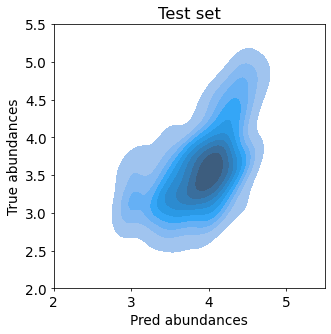

In [23]:
plt.figure(dpi=70, figsize=(5, 5))

sns.kdeplot(
    x = np.log10(lm.predict(seq_freq_and_abundance.query('seq in @sequences_test')[aa_list])),
    y = np.log10(seq_freq_and_abundance.query('seq in @sequences_test')['Median_molecules_per_cell']),
    fill=True
).set(
    title = 'Test set',
    xlabel = 'Pred abundances',
    ylabel = 'True abundances',
    xlim = (2, 5.5),
    ylim = (2, 5.5)
);